In [1]:
import matplotlib.pyplot as plt
import numpy as np
import control.matlab as ctl

from scipy.optimize import minimize, check_grad, approx_fprime
from scipy.optimize import LinearConstraint, BFGS

In [175]:
# === 設計仕様の決定 ===
# サンプリングタイムと演算子
Ts = 0.0005
s = ctl.tf([1,0], [1])         # ラプラス演算子 s
z = ctl.tf([1, 0], [1], Ts)    # 時間進み演算子 z

# 参照モデル Td
tau = 0.010
Td = ctl.c2d(1/(tau*s + 1), Ts)    # ゼロ次ホールドで離散化した一次遅れ系

# 制御器構造 C(rho)
#Crho = lambda rho: rho[0] + rho[1]*Ts/(1-z**-1) + rho[2]*(1-z**-1)/Ts # PID制御器
Crho = lambda rho: rho[0] + rho[1]/(1-z**-1) # PI制御器

# 初期制御器のパラメータ
#rho0 = np.array([10, 0.0, 0.0])              # 適当な比例制御器（安定化する）
rho0 = np.array([10.0, 1.0])              # 適当な比例制御器（安定化する）

# 初期制御器 C0
C0 = Crho(rho0)


C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


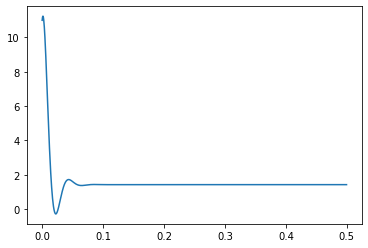

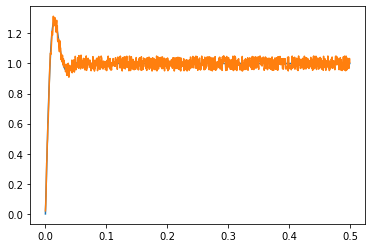

In [176]:
# === 入出力データの取得 ===
# データ取得に用いる入力信号 r (ステップ信号)
N  = 1000           # データ数
r0 = np.ones(N)     # 信号のベクトル

# 制御対象モデル P
Tp = 0.050
Kp = 0.7
P = ctl.c2d(Kp/(Tp*s + 1), Ts)

# 初期の閉ループシステム
T0 = P*C0/(1 + P*C0)
Tu0 = C0/(1 + P*C0)

# 制御対象の出力信号 y0
y0, t0, _ = ctl.lsim(T0, r0)

# 制御入力信号 u0
# u0, _, _ = ctl.lsim(C0, r0 - y0.flatten())
u0, _, _ = ctl.lsim(Tu0, r0)

# ノイズ
A = 0.05    # 振幅
noise = 2*A*(np.random.rand(round(len(t0)))-0.5) # ホワイトノイズの生成f

# Anoise1 = 0.05
# fnoise1 = 0.5e3
# noise = Anoise1 * np.sin(2 * np.pi *fnoise1 * t0)

y0_noise = y0 + noise

plt.figure()
plt.plot(t0, u0)
plt.figure()
plt.plot(t0, y0)
plt.plot(t0, y0_noise)


In [177]:
def e_tilde(C, Td, u0, y0):
    _u, _, _ = ctl.lsim(C**-1, u0.flatten())
    r_tilde = _u + y0
    y_tilde, _, _ = ctl.lsim(Td, r_tilde.flatten())
    return y0 - y_tilde
    
def J_e_tilde(C, Td, y0, u0):
    # FRIT の評価関数
    _e_tilde = e_tilde(C, Td, u0, y0)
    return np.linalg.norm(_e_tilde, 2)**2

def J_e_tilde_jac(C, Td, u0):
    e_tilde_d_kp, _, _ = ctl.lsim(Td * C**(-2), u0.flatten())
    e_tilde_d_ki, _, _ = ctl.lsim(Td * C**(-2) /(1-z**-1), u0.flatten())
    e_tilde_d = np.array([e_tilde_d_kp, e_tilde_d_ki])
    _e_tilde = e_tilde(C, Td, u0, y0)
    jac_frit = 2 * np.dot(e_tilde_d, _e_tilde)
    return jac_frit

def J_e_tilde_hessian(C, Td, u0):
    jac = np.array([J_e_tilde_jac(C, Td, u0)])
    return np.dot(jac.T, jac)

# 最適化問題の評価関数 f(x)とそのヤコビアン
f = lambda x: J_e_tilde(Crho(x), Td, y0, u0)
f_jac = lambda x: J_e_tilde_jac(Crho(x), Td, u0)
f_hessian = lambda x: J_e_tilde_hessian(Crho(x), Td, u0)

#確認
eps = np.sqrt(np.finfo(float).eps)

print(f_jac((1, 2)))
print(approx_fprime((1, 2), f, [eps, eps]))

print(f_jac((10, 2)))
print(approx_fprime((10, 2), f, [eps, eps]))

print(check_grad(f, f_jac, [10, 2]))

print(f_hessian([10, 2]))

# f = lambda x: J_e_tilde(Crho(x), Td, y0_noise, u0)


C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


[-0.18770827  0.02894958]
[-0.18770814  0.02894962]
[-0.07625364  0.983679  ]
[-0.07625461  0.9836781 ]
1.3197300858616417e-06
[[ 0.00581462 -0.07500911]
 [-0.07500911  0.96762438]]


In [179]:
f = lambda x: J_e_tilde(Crho(x), Td, y0_noise, u0)
# === FRITによる設計 ===

def callbackFunc_trust(xk, state):
    callbackFunc_trust.epoch += 1
    print("{}: Jfrit = {:4.4f}, rho = {}".format(
        callbackFunc_trust.epoch, 
        state["fun"], 
        np.round(xk, 4)))
callbackFunc_trust.epoch = 0
    
def callbackFunc(xk):
    callbackFunc.epoch += 1
    print("{}: Jfrit = {:4.4f}, rho = {}".format(
        callbackFunc.epoch,
        f(xk),
        np.round(xk, 4)))    
callbackFunc.epoch = 0

# 制約条件（すべてのパラメータが正）
cons = LinearConstraint(
    np.eye(rho0.size), 
    np.zeros_like(rho0), 
    np.array([np.inf, np.inf]))

# 最適なパラメータ rho

# print("trust-constr")
# optResult = minimize(f, rho0,
#                      method="trust-constr", 
#                      jac=f_jac,
#                      hess=BFGS(),
#                      bounds=((0, np.inf), (0, np.inf)),
#                      options={"maxiter":np.inf, "disp":True},
#                      callback=callbackFunc_trust
#                       )
print("TNC")
optResult = minimize(f, rho0,
                     method="TNC", 
                     jac=f_jac,
                     hess=f_hessian,
                     bounds=((0, np.inf), (0, np.inf)),
                     options={"disp":True},
                     callback=callbackFunc
                      )
print("Powell")
callbackFunc.epoch = 0
optResult = minimize(f, rho0,
                     method="Powell",
                     bounds=((0, np.inf), (0, np.inf)),
                     options={"maxiter":np.inf, "disp":True},
                     callback=callbackFunc
                     )
# print("L-BFGS-B")
# callbackFunc.epoch = 0
# optResult = minimize(f, rho0,
#                      method="L-BFGS-B",
#                      jac=f_jac,
#                      bounds=((0, np.inf), (1, np.inf)),
#                      options={"maxiter":np.inf, "disp":True},
#                      callback=callbackFunc
#                      )

rho = optResult["x"]
# 設計した制御器 C
C = Crho(rho)  # 制御器を求める

# 評価値
print("初期の評価値\t： {:5.3f}".format(f(rho0)))
print("設計後の評価値\t： {:5.3f}".format(f(rho)))


TNC
1: Jfrit = 2.1367, rho = [10.902   0.0742]
2: Jfrit = 2.1274, rho = [10.8619  0.0675]
3: Jfrit = 0.8887, rho = [7.2621 0.0638]
4: Jfrit = 0.8795, rho = [6.8776 0.0641]
5: Jfrit = 0.8652, rho = [7.0118 0.0685]
6: Jfrit = 0.8652, rho = [6.9809 0.0689]
Powell
1: Jfrit = 4.0623, rho = [15.8192  0.0819]
2: Jfrit = 0.8651, rho = [7.0235 0.0691]
3: Jfrit = 0.8650, rho = [7.0069 0.0691]
Optimization terminated successfully.
         Current function value: 0.865024
         Iterations: 3
         Function evaluations: 88
初期の評価値	： 8.709
設計後の評価値	： 0.865


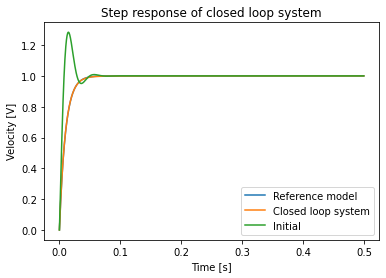

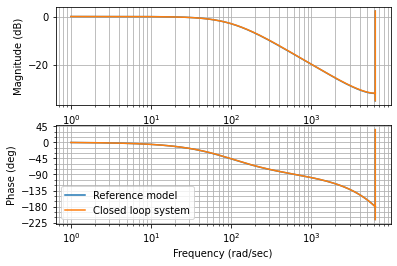

In [180]:
# === 性能の確認 ===
# 制御器を実装したシステム全体 G
G = ctl.minreal(ctl.feedback(P*C, 1), verbose=False)

# ステップ応答
plt.figure()
plt.title("Step response of closed loop system")
timeRange = t0
ym, _ = ctl.step(Td, timeRange)
yg, _ = ctl.step(G, timeRange)
plt.plot(timeRange, ym)
plt.plot(timeRange, yg)
plt.plot(t0, y0)
plt.xlabel("Time [s]")
plt.ylabel("Velocity [V]")
plt.legend(['Reference model', 'Closed loop system', 'Initial'], loc='lower right')

# ボード線図表示
plt.figure()
plt.title("Bode plot of closed loop system")
ctl.bode(Td, G)
plt.legend(['Reference model', 'Closed loop system'], loc='lower left')

plt.show()